# RAL "Statistical Analysis Lab" Prerequesite Material

Please get yourself familiar with the following terminology and basic `RooFit` functionality.

In [1]:
import roofitbasics as rs
import ROOT

Welcome to JupyROOT 6.24/01


## Basic Statistical Analysis Terminology

Here are some generic definitions of things involved with statistical analysis. Make sure you understand them abstractly before we go on to see how they are represented in `RooFit`:

| Term | Description |
|------|-------------|
| Variable | A fundamental type that has a value. They are often a continuous real-valued quantity but can also be a discrete (categorical) valued quantity. |
| Observable | A variable that features in a dataset, representing a measurable quantity.  |
| Global Observable | A special type of observable in a dataset that takes a value that is independent of the events, so it has the same value for every event and is defined even if the dataset has no events in it. |
| Dataset | A collection of events that each have a set of values for the non-global observables of the dataset, and potentially also a weight. The dataset may also have a collection of global observable values. Think of the events like rows in a table and the non-global observables are the columns. The global observables are an extra set of values that sit alongside the table. Examples of non-globable observables are channel category and bin number. An example of a global observable is the integrated luminosity. |
| PDF | A function of variables that, when evaluated, will return a probability density defined over a particular subset of the variables that is called the *normalization set* of the PDF. All the variables in the normalization set are considered to be observables. 
| Parameter | A variable of a function that is not an observable (i.e. for PDFs is a variable of the PDF that is not in the normalization set).
| Likelihood | A function of parameters defined by the combination of a PDF with a Dataset (the observables of the dataset define the normalization set of the PDF). The value of the likelihood function = $p(g)\prod_i p(o_{i})^{w_i}$ (where $g$ are the global observables, $o_i$ and $w_i$ are the observables and weight respectively of the ith event) and often the negative log of this function is evaluated instead: -($\Sigma_i w_i log(p(o_i)) +log(p(g)))$


In RooFit (as well as most other statistical analysis packages) the actual value of the likelihood function may not correspond to precisely the likelihood, but may instead include a multiplicative factor (additive in NLL) that depends only on data (i.e. does not depend on the parameters). This is acceptable because it is never the absolute value of likelihood that we are interested in, but we study likelihood ratios and delta-log-likelihood, so this factor cancels out. 

Datasets can be binned or unbinned. When a dataset is binned this means all the events that fall in a given bin of some observable are combined into a single event, with the observable value normally chosen to be the bin center, and the event's weight equal to the sum (of weights) of the events in the bin. 


## Basic RooFit functionality

This notebook will cover only the essential RooFit concepts that you need to understand for the following statistical analysis tutorial. RooFit has a vast set of capabilities and functionality, and this notebook is careful to tread a particular path through the toolkit to expose you to only the essential concepts and **nothing more**. Please do not be afraid to stray from the path if you are interested in exploring further, but know that, sadly, what you find in other parts of RooFit do not always appear to be what they seem or behave how you might first think.

### Variables: RooRealVar and RooCategry
There are two fundamental variables types in `RooFit`:

  1. `RooRealVar` is a continuous variable, with an optional range defined by lower and upper bound. They can also be optionally given an associated error. It can also have a binning, which can be relevent for observables, but this is not a feature we will make use of.
  2. `RooCategory`is a discrete variable with a defined set of possible values.
  
`RooRealVar` will appear as parameters of functions and as observables in datasets. `RooCategory` you will only encounter being used as an observable that identifies which *channel* an event lives in (the discrete values represent the different channels). Since we wont encounter them otherwise, we will focus on interacting with `RooRealVar`:

| Method | Description |
|--------|-------------|
|`v.GetName()`| Name of the variable |
|`r.getVal()`| Access current value of a `RooRealVar`|
|`c.getIndex()`| Access current value of a `RooCategory`|
|`r.setConstant(True)`| Mark the var constant (use `False` to mark it floating) |
|`r.isConstant()` | Is the variable constant? (can also do `r.getAttribute("Constant")`) |
|`r.getMin()` | Get the lower boundary of the range (lowest possible value of variable) |
|`r.getMax()` | Get the upper boundary of the range (highest possible value of variable) |
|`r.setVal(x)`| change the value of the variable (respects range boundaries i.e. you cannot set value outside of the min and max) |
|`r.setRange(low,high)`| change the range of the RooRealVar |
|`r.hasError()`| does the var have a defined error? |
|`r.getError()`| get the error |
|`r.setError(x)`| set the error |
|`r.Print()`| shows current value, error (if defined), range, and constant status (marked by a "C" for constant) |


In [ ]:
r = rs.getObject("myVar")

# play here with access r, e.g.
r.Print()

In [ ]:
rs.test_1a( True ) # is r constant? Delete as appropriate

# change r's value to 7 and set its error to 4, and set its range to 0-10
# CODE HERE

r.setVal(7);r.setError(4);r.setRange(0,10)

rs.test_1b(r)

r.Print() # see the impact of your changes

### Collections of variables: RooArgSet and RooArgList
RooFit has two container types for collections of variables:

  1. A `RooArgList` behaves a bit like a python list (or c++ vector) of variables, i.e. access ith variable with `l[i]` **but you can't use negative numbers to access elements from the back**
  2. A `RooArgSet`, is an unordered set of variables, but you can access variable "v" with `s["v"]`, so in this sense it is a bit like a python dictionary. 
  
You will encounter both in this tutorial. You need to know how to access the variables in the collections and how to copy values from one collection to another. Both collection types share many methods, here's some to be aware of:

| Method name | Description |
|-------------|-------------|
|`coll.Print()` | print names of the variables in the collection|
|`coll.Print("v")`| print names and values of the variables|
|`coll.size()`| number of variables in the collection (len(coll) also works)|
|`coll.find(vName)`| find variable by name, returns null object (`==None`) if not found|
|`coll.clone("newName")`| create a copy of the collection, but containing references to the same variables |
|`coll.snapshot()`| create an *indepedent copy* of the contents of the collection (i.e. copies the content as well) |
|`coll.assignValueOnly(another_coll)`| copy values from any variable in another_coll with matching names over to coll|
|`coll.selectCommon(another_coll)` | a new collection containing variables in coll that are also in another_coll (by name)|
|`coll.selectByAttrib("Constant",True)`| select only the constant variables (change to False to select floating)|
|`coll.setAttribAll("Constant",True)`| set all constant (change to False to make all floating)|
|`coll.add(var_or_coll`)| adding a variable to a collection or all variables in a collection to this collection|
|`coll.remove(var_or_coll)`| remove a variable or collection of variables from this collection |


In [ ]:
s = rs.getObject("mySet")
l = rs.getObject("myList")

In [ ]:
# What is the name of last variable in l ? 
rs.test_2a( l[l.size()-1].GetName() )

In [ ]:
# what is the value of variable called "bar" in s ?
rs.test_2b( s["bar"].getVal() )

In [ ]:
# Create a collection of the floating variables in s
rs.test_2c( s.selectByAttrib("Constant",False)  )

In [ ]:
# Create a collection of the variables that are in s but not in l (by name)
# hint: one solution would involve starting by creating a clone of the set
c = s.clone("newSet")
c.remove(s.selectCommon(l))
rs.test_2d( c )

### Datasets: RooDataSet (with a RooArgSet)

Recall that a dataset is:

  * a table of (possibly weighted) "events" where the columns are the observables, 
  * and an additional collection of global observable values. 
  
In RooFit the values of the global observable are stored in a `RooArgSet` snapshot, and the values of the observables for each event are held in a `RooDataSet`.

Note that RooFit will soon allow the `RooDataSet` to store the `RooArgSet` of global observable values, but at the moment you have to carry around the pair of objects yourself. 

In this tutorial you wont be creating any datasets yourself so we will focus only on how you access the contents of a `RooDataSet`. Here are the most basic operations you might do with a dataset:

| Method name | Description |
|-------------|-------------|
|`d.get(i)`| Returns a `RooArgSet` of the ith entry (row) of a dataset |
|`d.numEntries()`| Number of entries in the dataset  |
|`w.weight()`| Weight of the row of the dataset that was last accessed with `get` |
|`w.sumEntries()`| Returns sum of the weights of all the entries in the dataset |

The `RooArgSet` of the global observable values for the dataset will currently stored elsewhere but in future versions of ROOT it will be part of the dataset (as it should be).

In [ ]:
d = rs.getObject("myData")
d.Print()

In [ ]:
# what is the name of the discrete variable in the dataset?

for v in d.get():
    if v.ClassName()=="RooCategory": varName = v.GetName()

test_3a( varName )

In [ ]:
# what is the weight of the last entry in the dataset?

d.get( d.numEntries() - 1 )
weight = d.weight()

test_3b( weight )

### PDFs: RooAbsPdf
In RooFit a RooAbsPdf is just a **function of variables** with some complicated built-in machinary for normalizing the pdf. 

Get the variables of the function using `model.getVariables()` which returns a `RooArgSet` of all the variables of the model.

To evaluate the PDF at a particular point in the observable space, call `getVal(normSet)` where normSet is a RooArgSet of the variables of the PDF to treat as observables. you must first have set all the observables to the value you want to evaluate at.

In [2]:
m = rs.getObject("myModel")
m.Print()

RooExtendPdf::myModel[ pdf=myPdf n=yield ] = 1


test_4a: CORRECT


Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


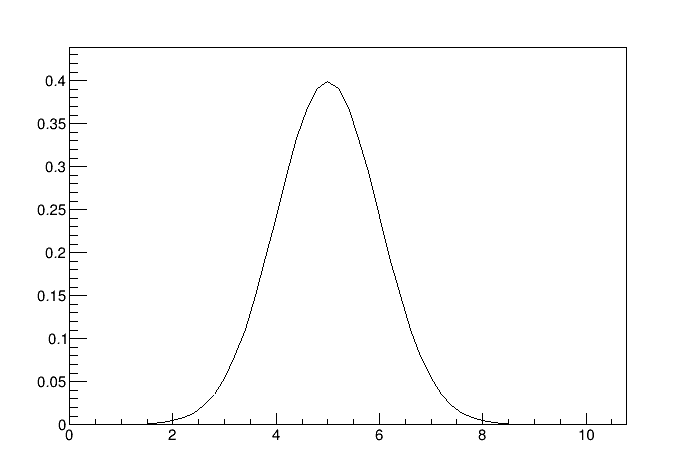

In [3]:
# Exercise: plot a graph of the PDF as a function of variable "x" (i.e. consider "x" to be the observable)
# The plot should cover points from the min up to the max value of the variable range in steps of 0.2

graph = ROOT.TGraph()

var = m.getVariables().find("x")

import numpy as np
for x in np.arange(var.getMin(),var.getMax(),0.2):
    var.setVal( x )
    graph.AddPoint(var.getVal(),m.getVal(ROOT.RooArgSet(var)))

rs.test_4a(graph)

graph.Draw("AL")
ROOT.gPad.Draw() # show the current canvas

`RooAbsPdf`, like all functions in `RooFit`, are actually built as functions of other functions. In this way, all functions can be thought as trees (or graphs to use the proper terminology), where the nodes of the tree are the functions and the branches connect to the functions that the function depends on (the *servers*). The fundamental types (`RooRealVar` and `RooCategory`) are functions that depend on no other functions, so are the *leafs* of these trees. 

![Example of a tree graph](treegraph.png "Tree Graph")

In the above picture, nodes 8-14 would be fundamental types, and the other nodes would be functions or PDFs. 

In `RooFit` terminology, every function has a list of `servers` that it depends on, as well as a list of `clients` that depend on it:

  * A *top-level* pdf (or function) is one that has no clients (it's at the top of the tree).
  * The fundamental types have no servers (it's at the bottom of the tree).
  
The `clients()` and `servers()` method respectively return an iterable over the clients and servers of the function respectively. For example, you can use `len(pdf.clients())==0` to identify the top-level pdf in a list of pdfs.

### Saving to models and datasets: RooWorkspace

The `RooWorkspace` is an object that can contains datasets, models, and in fact can store all sorts of other types of object. It is the standard way that `RooFit` objects are saved to a file. 

Note: The methods below work because a `RooArgSet` (or `RooArgList`) are allowed to contain functions and pdfs as well as fundamental type variables.

| Method name | Description |
|-------------|-------------|
|`w.allVars()`| Returns a `RooArgSet` of all the continuous-valued variables in the workspace. |
|`w.allCats()`| Returns a `RooArgSet` of all the discrete-valued variables in the workspace. |
|`w.allPdfs()`| Returns a `RooArgSet` of all the pdfs in the workspace. |
|`w.allData()`| Returns an `std::list` of the datasets in the workspace (can iterate over like a python list). |
|`w.getSnapshot(name)` | Returns a `RooArgSet` that has been saved to the workspace. This is currently how global observable values of datasets are saved in workspaces. |


In [ ]:
w = rs.getObject("myWorkspace")

In [ ]:
# What is the name of the top-level pdf in the workspace (hint: see the info about servers and clients of PDFs in the section above)

pdfName = [ a.GetName() for a in w.allPdfs() if len(a.clients())==0 ][0]

rs.test_5a( pdfName )

In [ ]:
# The global observables for the single dataset in the workspace is in a snapshot with the same name as the dataset.
# Access the snapshot and give the name and value of the global observable (there's only 1 in the set):
# hint: convert std::list to python list with: py_list = [a for a in std_list]

glob = w.getSnapshot([d.GetName() for d in w.allData()][0]).first()
globName = glob.GetName()
globVal = glob.getVal()

rs.test_5b( globName, globVal )

### Fit Results: RooFitResult
A `RooFitResult` is the type of object used to hold the information about the result of a fit, which is just the minimization of a NLL function. Specifically, a `RooFitResult` has the following important methods:

| Method name | Description |
|-------------|-------------|
|`fr.status()` | Status code of the fit. 0 means the fit was good, non zero means some aspect of the result is suspect/untrustworthy. The interpretation of non-zero status codes is regretfully 'minimizer specific' i.e. it depends exactly how the fit was performed, but as a rule you should only fully trust fits with status = 0. |
|`fr.minNll()` | The post-fit value of the NLL function i.e. $-\text{ln}L(\alpha,\hat{\beta})$ where $\alpha$ are the constant parameters and $\beta$ are the floating parameters. |
|`fr.floatParsFinal()`| A `RooArgList` of the post-fit parameter values, with errors set to the hessian-estimated error. |
|`fr.constPars()` | A `RooArgList` of the parameter values of the constant parameters. |
|`fr.floatParsInit()` | A `RooArgList` of the pre-fit parameter values. |
|`fr.covarianceMatrix()` | Access the post-fit covariance matrix (as a `TMatrixD`) of the floating parameters. The order of the parameters in the `floatParsFinal()` list corresponds to the order of the elements in the covariance matrix. |

We haven't got any exercises for you to play with fit results ... but we will do a lot of that in the main session, so see you then!!!